# Project "English score"

### Description

Watching movies in original is polpular and working method to improve english skills. It is essential to give a student correct movie depending on his english level (understand 50-70 % of dialogs). Therefore teacher must firstly watch the movie and then desicde what is the level. It is time-consuming process. That's why it would be great idea to create a service that has an input as film and an output as English level for user.

### Objective

The main idea is about to develop ML-model that can make accurate prediction of film English level by its subtitles. 

### Project stages

1. Open given datasets and initial analysis.
2. Make detail researh of data and draw conclusions.
3. Do preprocessing and prepare data for learning.
4. Learning stage.
5. Overall conclusion.

### Data

As an input data we have a main catalog `English level`. 

The catalog has folder `English scores` which consist of Excel file `movies_labels` and folder `Subtitles all`. 

## Research analysis and preprocessing

In [409]:
# importing library that will be used during the project

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import pysrt
import re
import nltk
import transformers as tr

from nltk.corpus import wordnet, stopwords
from nltk.stem import WordNetLemmatizer 
from sklearn.linear_model import LogisticRegression
from imblearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split, cross_validate, cross_val_predict
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.neighbors import KNeighborsClassifier 
from sklearn import svm
from sklearn.metrics import accuracy_score

%matplotlib inline
%config InlineBackend.figure_format = 'svg' 
pd.options.mode.chained_assignment = None

from pylab import rcParams
rcParams['figure.figsize'] = 13, 5

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore")

# !pip install pysrt
# !pip install transformers
# !pip install -U scikit-learn
# nltk.download('omw-1.4')
# nltk.download('averaged_perceptron_tagger')
# nltk.download('punkt')

### Research

Firstly it is crutial to make quality research given information.

Let's put in the variable `file_movies_labels` a path to the Excel file that is located in folder `English_scores`.

In [410]:
file_movies_labels = os.getcwd() + '/English_level/English_scores/movies_labels.xlsx'

In [411]:
os.getcwd()

'C:\\Users\\VirtusMan\\Downloads'

In [412]:
# Opening file `movies_labels.xlsx` and transforming it to dataframe

movies_labels = pd.ExcelFile(file_movies_labels).parse('Sheet1')

In [413]:
movies_labels.head()

,id,Movie,Level
0,0,10_Cloverfield_lane(2016),B1
1,1,10_things_I_hate_about_you(1999),B1
2,2,A_knights_tale(2001),B2
3,3,A_star_is_born(2018),B2
4,4,Aladdin(1992),A2/A2+


In [414]:
#  Delete column `id` wchich duplicates indexes

movies_labels.drop(['id'], axis=1, inplace=True)

In [415]:
# Rename colums according to the standard

movies_labels.columns = ['movie', 'level']

In [416]:
movies_labels.head()

,movie,level
0,10_Cloverfield_lane(2016),B1
1,10_things_I_hate_about_you(1999),B1
2,A_knights_tale(2001),B2
3,A_star_is_born(2018),B2
4,Aladdin(1992),A2/A2+


In [417]:
movies_labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 241 entries, 0 to 240
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   movie   241 non-null    object
 1   level   241 non-null    object
dtypes: object(2)
memory usage: 3.9+ KB


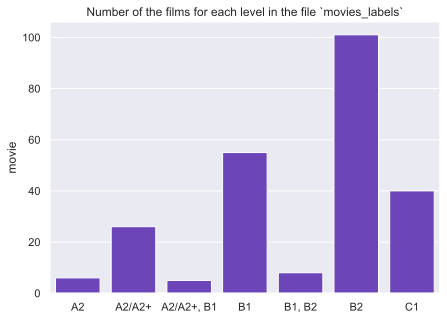

In [418]:
sns.set(style="darkgrid")
plt.figure(figsize=(7, 5))
sns.barplot(
    x=movies_labels.level.sort_values().unique(),
    y=movies_labels.groupby('level').count().movie,  
    estimator=sum,
    color = (0.4,0.2,0.8,0.9));
plt.title('Number of the films for each level in the file `movies_labels`');

Total number of the films is 241.

There are two main columns in table from `movies_labels.xlsx`: Movie and Level. Level shows what is the level of the given film.

Some levels have ambiguous value like 'A2/A2+, B1'. Let's delete such movies because it don't give a contrast in data. There is also label A2/A2+ where A2+ probably means that it's hirer then A2 but still lower then B1. Additionaly, 'B1, B2' can be both level, so if it can be B1 it should stay B1. Let's group such levels together.

Moreover there are no levels like A1 and C2. It can be because of lack such type of films (A1 - mostly simple children's film). Another reeason is there is no big difference between levels if we talk abot movies.

In [419]:
movies_labels = movies_labels.query('level != "A2/A2+, B1"')

In [420]:
movies_labels.replace('A2/A2+', 'A2', inplace=True)
movies_labels.replace('B1, B2', 'B1', inplace=True)

In [421]:
movies_labels.level.unique()

array(['B1', 'B2', 'A2', 'C1'], dtype=object)

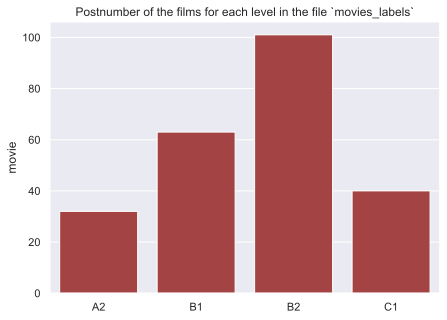

In [422]:
sns.set(style="darkgrid")
plt.figure(figsize=(7, 5))
sns.barplot(
    x=movies_labels.level.sort_values().unique(),
    y=movies_labels.groupby('level').count().movie,  
    estimator=sum,
    color = (0.7,0.2,0.2,0.9));
plt.title('Postnumber of the films for each level in the file `movies_labels`');

Now we have 4 labels: A2, B1, B2, C1. It's clearly seen that label 'B2' is the most frequent compare to others. Probably because huge amount of films is B2 level. That's why there is a risk of inbalanced dataset and poor quality learning of levels with A2 or C1 levels.

In this project we will use standart ways to solve this problem like using oversampling technique for balancing number of values. In the future development it is vital to add much more movies to train dataset.

### Preprocessing

It is needed to prepare data for learning. Preprocessisng consist of lemmatizing text and cleaning it from punctuation marks and stop words. In the end transform it into numbers - vectors. 

In [423]:
subtitles_all = os.getcwd() +'/English_level/English_scores/Subtitles_all'
content = os.listdir(subtitles_all)
print(content)

['.DS_Store', 'A2', 'B1', 'B2', 'C1', 'Subtitles']


In [424]:
# Dowload stop words

stopw = list(stopwords.words('english'))

In [425]:
def get_wordnet_pos(word):
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN)

In [426]:
# A function which input is a path to the file and its name 
# The output is lemmatized massive of words from text that is diveded by films and cleaned from punctuation marks

wnl = WordNetLemmatizer()

def clean_text (file_name, stop):
    encodings = ['', 'UTF-8-SIG', 'ISO-8859-1', 'utf-8', 'Windows-1252', 'ascii']
    n = 0 
    t = 0
    while t == 0:
        try:
            subs_file = pysrt.open(file_name, encoding=encodings[n])
            t+=1
            
        except UnicodeDecodeError:
            n+=1
            
    text_file = subs_file.text
    text_file = re.sub(r"[^a-yzZA-Y]", ' ', subs_file.text).lower()  
    text_file = [wnl.lemmatize(w, get_wordnet_pos(w)) for w in nltk.word_tokenize(text_file) if w not in stop]
    text_file = ' '.join(text_file)
    return text_file

In [427]:
# Path to catalog
path = '/English_level/English_scores/Subtitles_all/'
subtitles_all = os.getcwd() + path

content = os.listdir(subtitles_all)
print('Folders in Subtitles_all: ', content)    

Folders in Subtitles_all:  ['.DS_Store', 'A2', 'B1', 'B2', 'C1', 'Subtitles']


In [428]:
content.remove('.DS_Store')

Let's find out what is founded in the folder /Subtitles.

In [429]:
subs = pd.DataFrame(columns=['text', 'level'])
subs_all = pd.DataFrame(columns=['text', 'level'])

for folder in content:
    path_level = subtitles_all + folder + '/'
    with os.scandir(path_level) as listOfEntries:  
        for entry in listOfEntries:
            if entry.is_file():
                file_name = path_level + entry.name
                pat = os.path.splitext(entry.name)[0]
                if pat != '.DS_Store':
                    subs.text = pd.Series(clean_text(file_name, stopw))                 
                    if folder == 'Subtitles':
                        if movies_labels.movie.isin([pat]).sum() == 1:
                            # Labeling subs like their match from `movies_labels`
                            value = movies_labels[movies_labels.movie == pat].level.values
                            value = ';'.join(value)
                            subs.level = pd.Series(value, index=subs.index)
                        
                        else:
                            # Labeling '0' films that don't have the level                       
                            subs.level = pd.Series(0, index=subs.index)
                        
                    elif len(folder)==2 :
                        # Labeling subs like their folder-source
                        subs.level = pd.Series(folder, index=subs.index)
                    if len(folder)==2 :
                        # Labeling subs like their folder-source
                        subs.level = pd.Series(folder, index=subs.index)
                    # Source of the label
                    subs['folder'] = pd.Series(folder, index=subs.index)
                    
                    # Title of the movie
                    subs['movie'] = pd.Series(pat, index=subs.index)
                    
                    # Join together all data
                    subs_all = pd.concat([subs_all, subs], ignore_index=True)  

In [430]:
subs_all.sample(5)

,text,level,folder,movie
177,create encode bokutox www yify torrent com bes...,B1,Subtitles,Before_sunset(2004)
3,bird chirp nothing nothing always something da...,A2,A2,The Walking Dead-S01E04-Vatos.English
42,,B2,B2,"Crown, The S01E01 - Wolferton Splash.en"
140,previously suit walter guarantee win guarantee...,C1,C1,Suits S04E04 EngSub
167,indistinct conversation laugh mama tanya fieve...,A2,Subtitles,An_American_tail(1986)


In [431]:
subs_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 278 entries, 0 to 277
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    278 non-null    object
 1   level   278 non-null    object
 2   folder  278 non-null    object
 3   movie   278 non-null    object
dtypes: object(4)
memory usage: 8.8+ KB


In [432]:
print('Levels: ', subs_all.level.unique())

Levels:  ['A2' 'B1' 'B2' 'C1' 0]


In [433]:
print('Number of the film titiles: ', len(subs_all.movie.unique()))

Number of the film titiles:  278


In [434]:
print('Checking foldres in the catalog: ', subs_all.folder.unique())

Checking foldres in the catalog:  ['A2' 'B1' 'B2' 'C1' 'Subtitles']


In [435]:
subs_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 278 entries, 0 to 277
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    278 non-null    object
 1   level   278 non-null    object
 2   folder  278 non-null    object
 3   movie   278 non-null    object
dtypes: object(4)
memory usage: 8.8+ KB


Total number of objects is 278.

In [436]:
num_all_labl = len(subs_all[(subs_all.level != 0)].movie.unique())
print(' Number of labeled films: ', num_all_labl)

num_not_labl = len(subs_all[subs_all.level == 0].movie.unique())
print(' a Number of films that are not labeled: ', num_not_labl)

num_labl = len(subs_all[subs_all.folder != 'Subtitles'].movie.unique())
print(' b Number of labeled files from labeled folders A1, B1, B2, C2: ', num_labl)

num_other_labl = len(subs_all[(subs_all.level != 0) & (subs_all.folder == 'Subtitles')].movie.unique())
print(' c Number of the films that are from Subtitles and labeled in the file "movies_labels": ', num_other_labl)

num_not = num_all_labl-len(movies_labels.movie.unique())
print(' d Number of labeled files that are NOT in the file "movies_labels": ', num_not)


 Number of labeled films:  262
 a Number of films that are not labeled:  16
 b Number of labeled files from labeled folders A1, B1, B2, C2:  163
 c Number of the films that are from Subtitles and labeled in the file "movies_labels":  99
 d Number of labeled files that are NOT in the file "movies_labels":  29


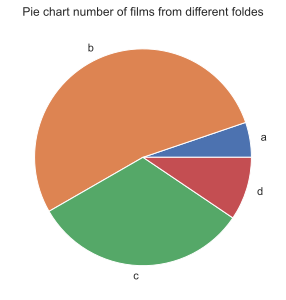

In [437]:
size_of_groups=[num_not_labl, num_labl, num_other_labl, num_not]
labels = ['a', 'b', 'c', 'd']
plt.pie(size_of_groups, labels=labels)
plt.title('Pie chart number of films from different foldes');

In [438]:
folders = subs_all.groupby('folder').count().movie
folders

folder
A2             6
B1            17
B2           107
C1            33
Subtitles    115
Name: movie, dtype: int64

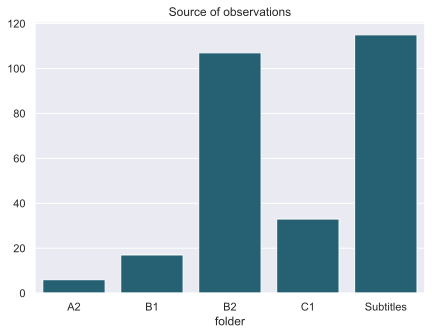

In [439]:
sns.set(style="darkgrid")
plt.figure(figsize=(7, 5))
plt.title('Source of observations')
sns.barplot(
    x=folders.index,
    y=folders.values,  
    estimator=sum,
    color = (0.1,0.4,0.5,0.9));

Folders A2, B1, B2, C1 have labeled observations. Subtitles in contrast has both labeled and not labeled data. Let's separate such films and make data for test.

In [441]:
no_label = subs_all[subs_all.level == 0]

In [442]:
no_label.movie.unique()

array(['Breaking_Bad_The_Movie(2017)',
       'Bren╨Т.Brown.The.Call.to.Courage.2019.720.NF.720p.DDP.5.1.x264-CafeFlix',
       'Casper', 'Forrest_Gump(1994)', 'Gogo_Loves_English',
       'Harry_Potter_and_the_philosophers_stone(2001)', 'Her(2013)',
       'Inside_out(2015)', 'Moulin_Rouge(2001)', 'Powder(1995)',
       'Pride_and_Prejudice', 'The_blind_side(2009)',
       'The_fault_in_our_stars(2014)', 'The_Ghost_Writer', 'Up(2009)',
       'Westworld_scenes_of_Dr_Robert_Ford'], dtype=object)

In [475]:
nl = no_label[no_label.movie == 'Pride_and_Prejudice'].index

In [476]:
nl

Int64Index([235], dtype='int64')

Title of movies and folders now are not interesting. We will delete it.

In [443]:
subs_all = subs_all[['text', 'level']]

In [447]:
subs_all.level.unique()

array(['A2', 'B1', 'B2', 'C1', 0], dtype=object)

### Embendding

In this project BERT-emdendding will be used for transforming words into vectors of numbers.

In [554]:
def tok (df):
    tokenizer_class, pretrained_weights = (tr.BertTokenizer, 'bert-base-uncased')
    tokenizer = tokenizer_class.from_pretrained(pretrained_weights)
    tokenized = df.text.apply((lambda x: tokenizer.encode(x, add_special_tokens=True)))
    max_len = 0
    for i in tokenized.values:
        if len(i) > max_len:
            max_len = len(i)
    print('Max lenght of vector in dataset: ', max_len)
    padded = [i + [0]*(max_len-len(i)) for i in tokenized.values]
    objects = pd.DataFrame(padded)
    objects['level'] = df.level
    return objects

In [564]:
data = tok(subs_all)

Token indices sequence length is longer than the specified maximum sequence length for this model (2016 > 512). Running this sequence through the model will result in indexing errors


Max lenght of vector in dataset:  10581


In [565]:
data.level.unique()

array(['A2', 'B1', 'B2', 'C1', 0], dtype=object)

In [566]:
unlabel = data[data.index.values==235].drop(['level'], axis=1)
data  = data[data.level != 0]

In [567]:
unlabel

,0,1,2,3,4,5,6,7,8,9,...,10571,10572,10573,10574,10575,10576,10577,10578,10579,10580
235,101,2189,2189,8529,2189,2189,2189,14076,14433,2189,...,0,0,0,0,0,0,0,0,0,0


In [520]:
df_train, df_test = train_test_split(data, test_size=0.15, random_state=1000)

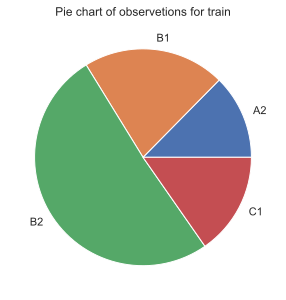

In [521]:
train = df_train.groupby('level').count()
plt.pie(x=train[0], labels=train.index, normalize=True)
plt.title('Pie chart of observetions for train');

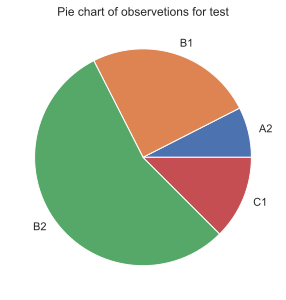

In [522]:
test = df_test.groupby('level').count()
plt.pie(x=test[0], labels=test.index, normalize=True)
plt.title('Pie chart of observetions for test');

Now train and test datasets splited randomly and there are all levels in both test and train sets .

### Learning stage

At first we should determine what type of algorithm would be suitible for our train datasets. We choose 3:

1. KNeighborsClassifier
2. SVC
3. LogisticRegression

In [609]:
model_knn = KNeighborsClassifier (n_neighbors=20, n_jobs=-1)
model_svc = svm.SVC(kernel='rbf', C=1, random_state=1)
model_lr =  LogisticRegression(random_state=1, n_jobs=-1, max_iter=1000)

In [610]:
def levels (df, level):
    df_level = df.copy()
    df_level.level = df_level.level.where(df_level.level == level, 0)
    df_level.level.replace(level, 1, inplace=True) 
    return df_level

In [611]:
def class_level(df):
    result_df = pd.DataFrame(columns=['accuracy', 'precision', 'recall', 'f1'])
    models = [model_knn, model_svc, model_lr]
    for model in models:
        for level in ['A2', 'B1', 'B2', 'C1']:

            df_level = levels(df, level)

            X = df_level.drop(['level'], axis=1)
            Y = df_level.level    
            
            if model == 'model_svc':
                pip = make_pipeline(StandardScaler(), SMOTE(random_state=1), model)
                res = cross_validate(pip, 
                                     X, 
                                     Y, 
                                     n_jobs=-1, 
                                     scoring=['accuracy', 'precision', 'recall', 'f1'],  
                                     cv=3)
            else:               
                pip = make_pipeline(SMOTE(random_state=1), model)
                res = cross_validate(pip, 
                                         X, 
                                         Y, 
                                         n_jobs=-1, 
                                         scoring=['accuracy', 'precision', 'recall', 'f1'],  
                                         cv=3)

            result_df.loc[level] = [round(res['test_accuracy'].mean(), 2), 
                            round(res['test_precision'].mean(), 2),
                            round(res['test_recall'].mean(), 2),
                            round(res['test_f1'].mean(), 2)]    
        display('Result of model: ', model)
        display(result_df)

In [612]:
pred = class_level(df_train)

'Result of model: '

KNeighborsClassifier(n_jobs=-1, n_neighbors=20)

,accuracy,precision,recall,f1
A2,0.14,0.13,1.00,0.23
B1,0.21,0.21,1.00,0.35
B2,0.49,0.46,0.32,0.37
C1,0.23,0.17,1.00,0.28


'Result of model: '

SVC(C=1, random_state=1)

,accuracy,precision,recall,f1
A2,0.87,0.00,0.00,0.00
B1,0.82,0.92,0.15,0.25
B2,0.56,0.63,0.51,0.51
C1,0.85,0.33,0.03,0.06


'Result of model: '

LogisticRegression(max_iter=1000, n_jobs=-1, random_state=1)

,accuracy,precision,recall,f1
A2,0.80,0.06,0.19,0.09
B1,0.69,0.40,0.45,0.38
B2,0.54,0.55,0.46,0.50
C1,0.74,0.29,0.41,0.29


We will mostly concentrate to accuracy and precision. It is clearly seen that LogisticRegression did the learning very well according to levels A2 and C1 compare to others. Despite of high accuracy for SVC for B1 and B2 there is zero value for levels A2 and C1. Probably it because of lack of data for these labels. KNeighborsClassifier has lower then 50 % accuracy for A2, B1, C1 which means it barely works.

In [613]:
model_svc = svm.SVC(kernel='rbf', C=1, random_state=1, probability=True)
model_lr =  LogisticRegression(random_state=1, n_jobs=-1, max_iter=1000)
models = []
fin_res = pd.DataFrame(columns=['Results of accuracy on test data'])
for level in ['A2', 'B1', 'B2', 'C1']:

    train = levels(df_train, level)
    test = levels(df_test, level)


    X_train = train.drop(['level'], axis=1)
    Y_train = train.level 

    X_test = test.drop(['level'], axis=1)
    Y_test = test.level   

    if level == 'B1':
        final_pip_1 = make_pipeline(StandardScaler(), SMOTE(random_state=1), model_svc)
        final_pip_1.fit(X_train, Y_train)
        fin_res.loc[level] = accuracy_score(final_pip_1.predict(X_test), Y_test)
        models.append(final_pip_1)
    if level == 'B2':
        final_pip_2 = make_pipeline(StandardScaler(), SMOTE(random_state=1), model_svc)
        final_pip_2.fit(X_train, Y_train)
        fin_res.loc[level] = accuracy_score(final_pip_2.predict(X_test), Y_test)
        models.append(final_pip_2)
    if level == 'A2':
        final_pip_3 = make_pipeline(StandardScaler(), SMOTE(random_state=1), model_lr)
        final_pip_3.fit(X_train, Y_train)
        fin_res.loc[level] = accuracy_score(final_pip_3.predict(X_test), Y_test)
        models.append(final_pip_3)
    if level == 'C1':
        final_pip_4 = make_pipeline(StandardScaler(), SMOTE(random_state=1), model_lr)
        final_pip_4.fit(X_train, Y_train)
        fin_res.loc[level] = accuracy_score(final_pip_4.predict(X_test), Y_test) 
        models.append(final_pip_4)

In [614]:
fin_res

,Results of accuracy on test data
A2,0.925
B1,0.775
B2,0.625
C1,0.825


In [615]:
modls

[Pipeline(steps=[('standardscaler', StandardScaler()),
                 ('smote', SMOTE(random_state=1)),
                 ('logisticregression',
                  LogisticRegression(max_iter=1000, n_jobs=-1, random_state=1))]),
 Pipeline(steps=[('standardscaler', StandardScaler()),
                 ('smote', SMOTE(random_state=1)),
                 ('svc', SVC(C=1, probability=True, random_state=1))]),
 Pipeline(steps=[('standardscaler', StandardScaler()),
                 ('smote', SMOTE(random_state=1)),
                 ('svc', SVC(C=1, probability=True, random_state=1))]),
 Pipeline(steps=[('standardscaler', StandardScaler()),
                 ('smote', SMOTE(random_state=1)),
                 ('logisticregression',
                  LogisticRegression(max_iter=1000, n_jobs=-1, random_state=1))])]

Final results of learning for test data is provided above. Let's calculate average score. 

In [616]:
print("Average accuracy score: ", round(fin['Results of accuracy on test data'].mean(), 2))

Average accuracy score:  0.79


## Unlabeled test

In [631]:
res_unlabeled = pd.DataFrame(columns=['prob'])
res_unlabeled.loc['A2'] = final_pip_3.predict_proba(unlabel)[0][1]
res_unlabeled.loc['B1'] = final_pip_1.predict_proba(unlabel)[0][1]
res_unlabeled.loc['B2'] = final_pip_2.predict_proba(unlabel)[0][1]
res_unlabeled.loc['C1'] = final_pip_4.predict_proba(unlabel)[0][1]

In [632]:
res_unlabeled

,prob
A2,0.000522
B1,0.334769
B2,0.334769
C1,0.000522


Classes B1 and B2 have equal probability.

## Conclusion

Let's summarize results:

1. Initial data was opened and analyzed. Total number of films 278 in final. There are 4 classes: A2, B1, B2, C1.
2. Data was preprocessed and cleaned and ready for learning by BERT tokenization.
3. KNeighborsClassifier, SVC, LogisticRegression were chosen to decide the best estimator. For class B1, B2 - SVC and A2, C1 - LogisticRegression were the best according to accuracy and precision.
4. Test data gave 0.79 accuracy.
5. Unlabeled text was also analyzed.